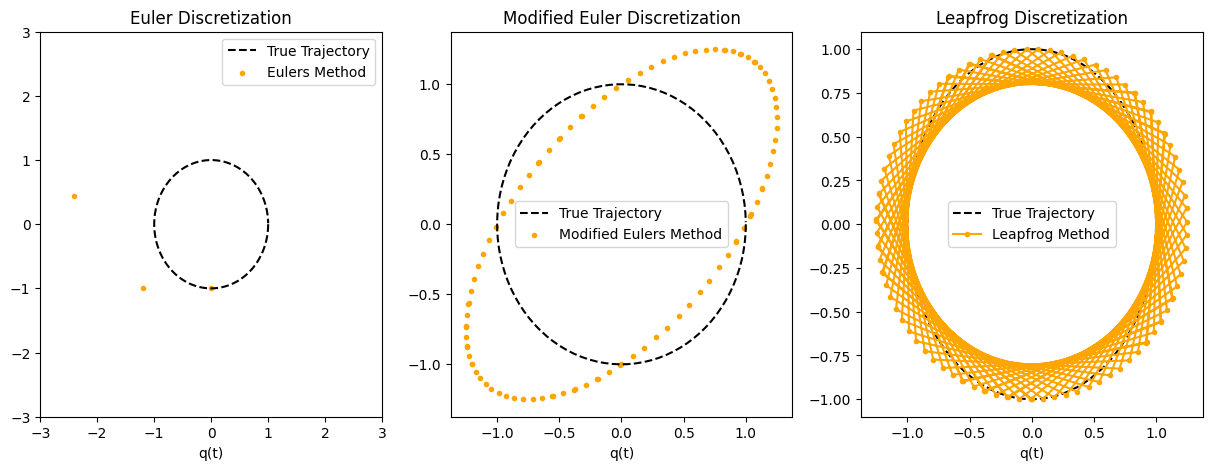

In [22]:
import matplotlib.pyplot as plt
import numpy as np

r = 1
a = 0

# Plot Trajectory 
t = np.linspace(0,6.268,100)

x = np.zeros(t.shape[0])
y = np.zeros(t.shape[0])

for i in range(len(t)):
    x[i], y[i] = r*np.cos(a + t[i]), -r*np.sin(a + t[i])

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,3,1)

ax1.plot(x,y, label = 'True Trajectory', linestyle = '--', color = 'black')
ax1.set_xlabel('q(t)')
ax1.set_xlim(-3, 3), ax1.set_ylim(-3, 3)
ax1.set_title('Euler Discretization')


# Euler's Method:

def U(q):
    return 0.5*q**2

def dUdq(q):
    return q

m = 1
ϵ = 1.2
num_steps = 1000
p_e, q_e = np.zeros(num_steps), np.zeros(num_steps)
p_e[0] = -1
q_e[0] = 0

for t in range(1, num_steps):
    p_e[t] = p_e[t-1] - ϵ * dUdq(q_e[t-1])
    q_e[t] = q_e[t-1] + ϵ * p_e[t-1]/m

ax1.scatter(q_e,p_e, alpha = 1, label = 'Euler''s Method', linestyle='-', marker = '.', color = 'orange')
plt.legend()


# Modified Euler:
num_steps = 100
p_m, q_m = np.zeros(num_steps), np.zeros(num_steps)
p_m[0] = -1
q_m[0] = 0

for t in range(1, num_steps):
    p_m[t] = p_m[t-1] - ϵ * dUdq(q_m[t-1])
    q_m[t] = q_m[t-1] + ϵ * p_m[t]/m

ax2 = fig.add_subplot(1,3,2)
ax2.plot(x,y, label = 'True Trajectory', linestyle = '--', color = 'black')
ax2.set_xlabel('q(t)')
ax2.set_title('Modified Euler Discretization')
ax2.scatter(q_m,p_m, alpha = 1, label = 'Modified Euler''s Method', linestyle='-', marker = '.', color = 'orange')
plt.legend()



# Leap-frog
num_steps = 100
p_l, q_l = np.zeros(num_steps), np.zeros(num_steps)
p_l[0] = -1
q_l[0] = 0

for t in range(1, num_steps):
    p_l[t] = p_l[t-1] - (ϵ/2) * dUdq(q_l[t-1])
    q_l[t] = q_l[t-1] + ϵ * p_l[t]/m
    p_l[t] = p_l[t] - (ϵ/2) * dUdq(q_l[t])

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Leapfrog Discretization')
ax3.set_xlabel('q(t)')
ax3.plot(x,y, label = 'True Trajectory', linestyle = '--', color = 'black')
ax3.plot(q_l, p_l, alpha = 1, label = 'Leapfrog Method', marker = '.', color = 'orange')
plt.legend()
plt.show()

### HMC for estimating posterior distribution in GP

In [1]:
from jax.scipy.stats import multivariate_normal
import jax.numpy as jnp
from jax import grad, jit, vmap
import jax.random as random

In [5]:
from jax.scipy.stats import multivariate_normal
import jax.numpy as jnp
from jax import grad, jit, vmap
import jax.random as random

@jit
def kernel(X1, X2, theta):
    """
    Computes the RBF kernel matrix between two sets of input vectors X1 and X2.
    
    Args:
        X1: A numpy array of shape (n1, d), representing the first set of input vectors.
        X2: A numpy array of shape (n2, d), representing the second set of input vectors.
        lengthscale: The lengthscale parameter of the RBF kernel.
        variance: The variance parameter of the RBF kernel.
    
    Returns:
        A numpy array of shape (n1, n2), representing the RBF kernel matrix.
    """
    variance, lengthscale = theta
    dist_sq = jnp.sum(X1**2, axis=1).reshape(-1, 1) + jnp.sum(X2**2, axis=1) - 2*jnp.dot(X1, X2.T)
    K = variance * jnp.exp(-0.5 * dist_sq / (lengthscale ** 2))
    return K 


@jit
def unnormalized_posterior(hyperparameters, noise_variance, X, y):
    """
    Computation of the unnormalized prior.
    :param Measurementplane self:
        An instance of the measurement plane.
    :param numpy array xo:
        A numpy array of priors.
    """
    Kxx = kernel(X, X, hyperparameters)
    Z = Kxx + noise_variance * jnp.eye(y.shape[0])
    try:
        likelihood = multivariate_normal.logpdf(y, mean=jnp.zeros((len(y))), cov=Z)
    except FloatingPointError as e:
        print('got here!')
        return -jnp.inf
    
    # Sample from the prior distribution!
    prior_alpha = multivariate_normal.logpdf(hyperparameters, mean=jnp.zeros((2,)), \
                                                         cov=jnp.eye(2)*1.0)
    unnormalized_posterior = likelihood + prior_alpha 
    return unnormalized_posterior


@jit
def Uθ(hyperparameters, noise_variance, X, y):
    return -unnormalized_posterior(hyperparameters, noise_variance, X, y)


@jit
def dUdθ(hyperparameters, noise_variance, X, y):
    return grad(Uθ)(hyperparameters, noise_variance, X, y)

@jit
def kinetic_energy(p,m):
    return 0.5*jnp.sum( (p**2) /m)

@jit
def leapfrog_step(q, p, m, ϵ, noise_variance, X, y):
    p_half = p - 0.5 * ϵ * dUdθ(q, noise_variance, X, y)
    q_new = q + (ϵ/m) * p_half
    p_new = p_half - 0.5 * ϵ * dUdθ(q_new, noise_variance, X, y)
    return q_new, p_new 


def hmc_iteration(key, q, L, m, ϵ, noise_variance, X, y):
    key, subkey = random.split(key)
    # draw new vector for momentum variables
    p = random.normal(key, shape = q.shape)

    # start with current state
    q_new, p_new = q, p

    # simulate Hamiltonian Dyanmics for L steps using Leap
    for _ in range(L):
        q_new, p_new = leapfrog_step(q_new, p_new, m, ϵ, noise_variance, X, y)

    # take the negative of momentum vector at the end of L-step trajectory (Radford Neil MCMC for H.D)
    p_new = -p_new

    K_new, K_old = kinetic_energy(p_new,m), kinetic_energy(p, m)
    U_new, U_old = Uθ(q_new, noise_variance, X, y), Uθ(q, noise_variance, X, y)

    # NOTE: There is a subtle difference between min and minimum.
    accept_reject_prob = jnp.minimum(1, jnp.exp(K_old + U_old - K_new - U_new)) 

    if random.uniform(subkey) <= accept_reject_prob:
        q = q_new
    
    return q, key


def hmc_sampling(init_hyperparams, noise_variance, X, y, m, ϵ, L, num_samples, num_warmup):
    samples = []
    key = random.PRNGKey(0)
    q = init_hyperparams

    for i in range(num_samples + num_warmup):
        q, key = hmc_iteration(key, q, L, m, ϵ, noise_variance, X, y)

        if i >= num_warmup:
            samples.append(q)

    return jnp.array(samples)

In [6]:
init_hyperparams = jnp.array([1.0, 1.0])  # initial values for the hyperparameters
m = 1.0  # mass
epsilon = 0.01  # step size
L = 10  # number of Leapfrog steps
num_samples = 50000
num_warmup = 10000
noise_variance = 0.2

# Test data
rng_key = random.PRNGKey(0)
f_sin = lambda x: (jnp.sin(x)).flatten()
X = random.uniform(rng_key, minval= -4, maxval= 4, shape=(10,1))
y = f_sin(X)

samples = hmc_sampling(init_hyperparams, noise_variance, X, y, m, epsilon, L, num_samples, num_warmup)

posterior_mean = jnp.mean(samples, axis=0)
posterior_std = jnp.std(samples, axis=0)

print ('Mean of \u03B8:', posterior_mean)
print ('Std of \u03B8:', posterior_std)


Mean of θ: [0.77279794 0.48223686]
Std of θ: [0.43298942 1.3751241 ]


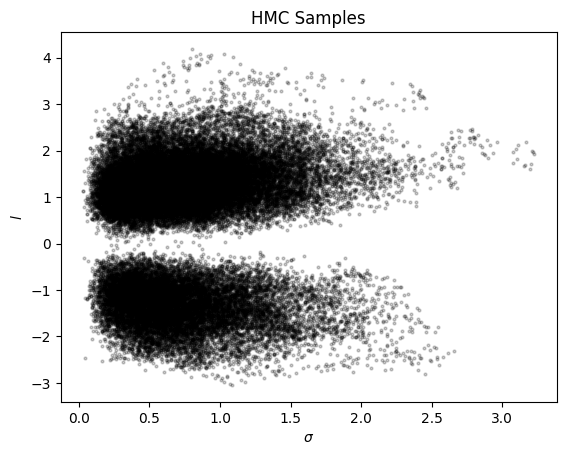

In [8]:
import matplotlib.pyplot as plt

plt.plot(samples[2000:,0], samples[2000:,1], 'ko', markersize=2, markerfacecolor='k', alpha=0.2)
plt.xlabel('$\sigma$')
plt.ylabel('$l$')
plt.title('HMC Samples')
plt.show()

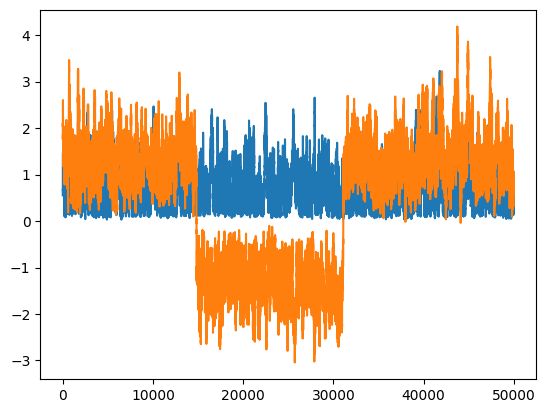

In [9]:
plt.plot(samples)
plt.show()

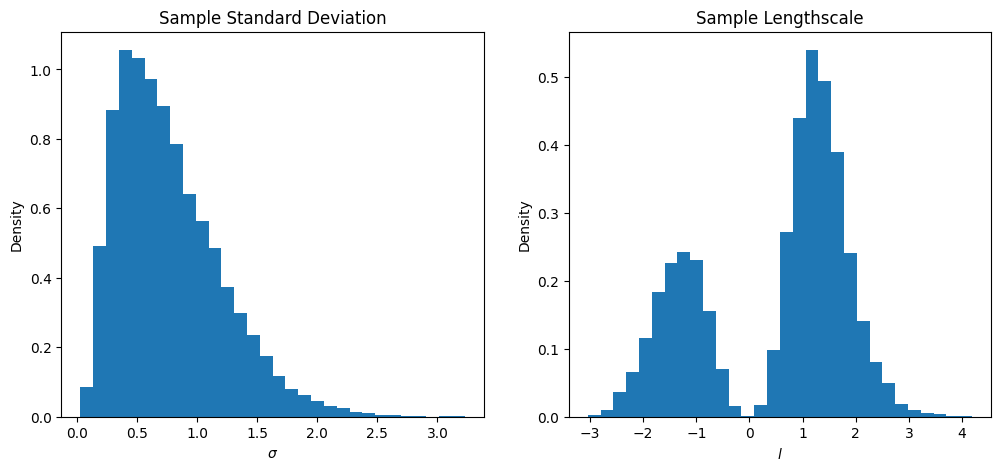

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(samples[:, 0], bins=30, density=True)
axes[0].set_title('Sample Standard Deviation')
axes[0].set_xlabel('$\sigma$')
axes[0].set_ylabel('Density')

axes[1].hist(samples[:, 1], bins=30, density=True)
axes[1].set_title('Sample Lengthscale')
axes[1].set_xlabel('$l$')
axes[1].set_ylabel('Density')

plt.show()


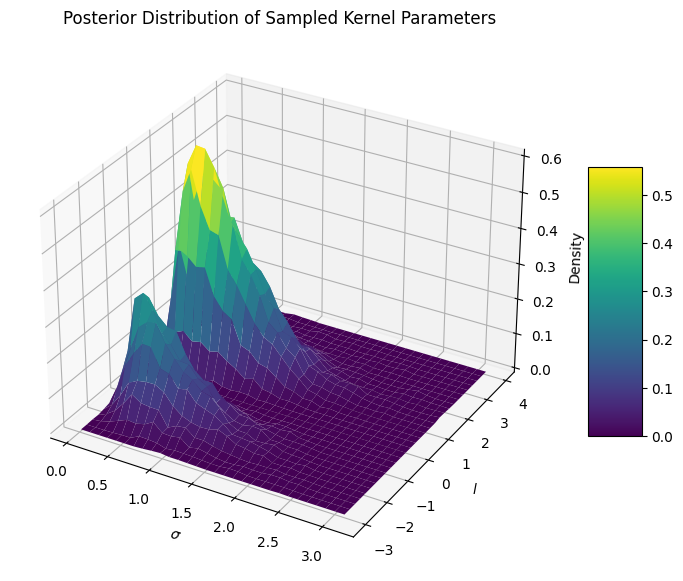

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Compute the 2D histogram
H, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=30, density=True)

# Create meshgrid for the plot
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, H.T, cmap='viridis', linewidth=0, antialiased=True)

ax.set_title('Posterior Distribution of Sampled Kernel Parameters')
ax.set_xlabel('$\sigma$')
ax.set_ylabel('$l$')
ax.set_zlabel('Density')

# Add a color bar to show the colormap scale
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


In [12]:
# Sample from posterior

# Set a random seed for reproducibility
key = random.PRNGKey(0)

# Generate random samples for each parameter using the posterior mean and standard deviation
num_samples = 1000  # Number of samples to generate

# For variance (sigma)
key, subkey = random.split(key)
variance_samples = random.normal(subkey, shape=(num_samples,)) * posterior_std[0] + posterior_mean[0]

# For lengthscale (l)
key, subkey = random.split(key)
lengthscale_samples = random.normal(subkey, shape=(num_samples,)) * posterior_std[1] + posterior_mean[1]


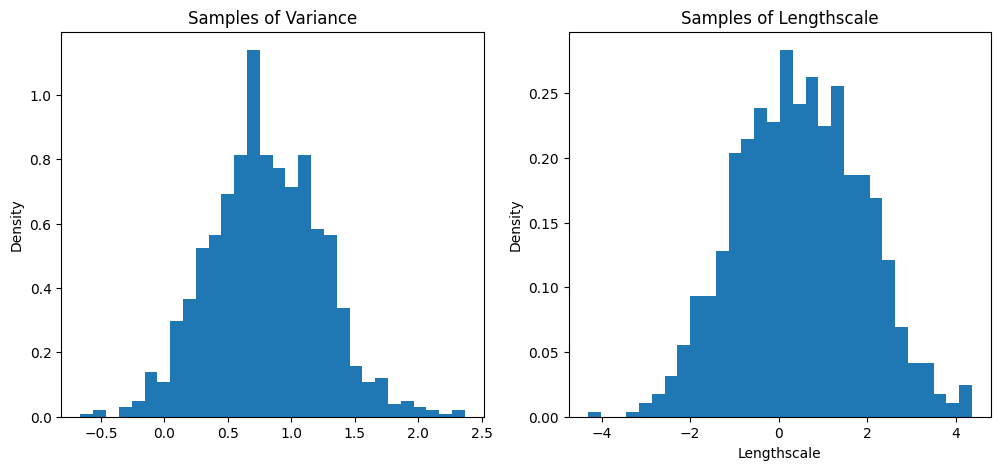

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(variance_samples, bins=30, density=True)
axes[0].set_title('Samples of Variance')
axes[0].set_xlabel('')
axes[0].set_ylabel('Density')

axes[1].hist(lengthscale_samples, bins=30, density=True)
axes[1].set_title('Samples of Lengthscale')
axes[1].set_xlabel('Lengthscale')
axes[1].set_ylabel('Density')

plt.show()


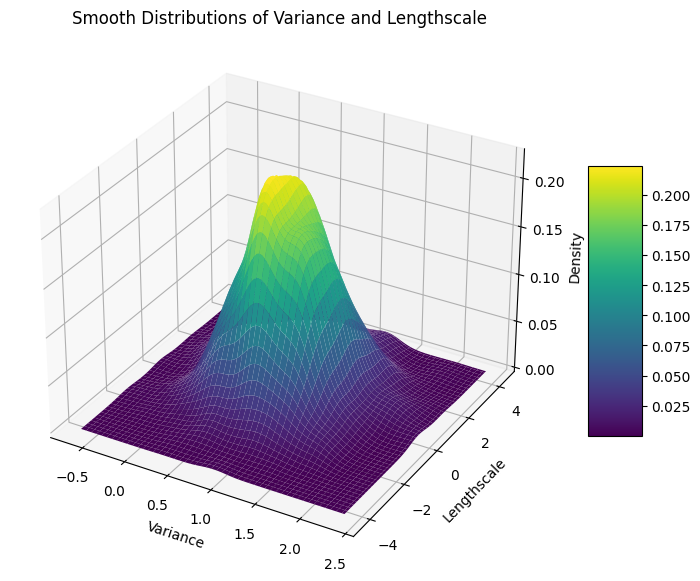

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Perform Gaussian kernel density estimation
kde = gaussian_kde(np.vstack([variance_samples, lengthscale_samples]))

# Create a grid for plotting
x = np.linspace(variance_samples.min(), variance_samples.max(), 100)
y = np.linspace(lengthscale_samples.min(), lengthscale_samples.max(), 100)
X, Y = np.meshgrid(x, y)

# Evaluate the KDE on the grid
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=True)

ax.set_title('Smooth Distributions of Variance and Lengthscale')
ax.set_xlabel('Variance')
ax.set_ylabel('Lengthscale')
ax.set_zlabel('Density')

# Add a color bar to show the colormap scale
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


In [15]:
import plotly.graph_objects as go

# Create a surface plot with the estimated probability density function
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z, colorscale='Viridis')])

fig.update_layout(
    title='Joint pdf of Kernel Parameters',
    scene=dict(
        xaxis_title='Variance',
        yaxis_title='Lengthscale',
        zaxis_title='Density',
    ),
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=20, r=20, b=20, t=80),
)

# Show the interactive plot
fig.show()


## Convergence Diagnostic

In [95]:
import jax.numpy as jnp
import numpy as np

num_samples = 5000
num_warmup = 1000

def gelman_rubin(chains):
    num_chains, num_samples, num_params = chains.shape
    mean_per_chain = jnp.mean(chains, axis=1)
    global_mean = jnp.mean(mean_per_chain, axis=0)

    B = num_samples / (num_chains - 1) * jnp.sum((mean_per_chain - global_mean) ** 2, axis=0)
    W = jnp.mean(jnp.var(chains, axis=1, ddof=1), axis=0)

    # Calculate variance estimate
    var = (1 - 1 / num_samples) * W + (1 / num_samples) * B

    # Compute the potential scale reduction factor (R-hat)
    R_hat = jnp.sqrt(var / W)

    return R_hat


num_chains = 4
chains = []

for i in range(num_chains):
    # Run HMC with different initial values for the parameters
    σ = np.absolute(np.random.normal())*posterior_std[0] + posterior_mean[0]
    l = np.absolute(np.random.normal())*posterior_std[1] + posterior_mean[1]
    init_hyperparams = jnp.array([σ, l])
    
    samples = hmc_sampling(init_hyperparams, noise_variance, X, y, m, epsilon, L, num_samples, num_warmup)
    chains.append(samples)

chains = jnp.stack(chains)

R_hat = gelman_rubin(chains)
print("R-hat values:", R_hat)

R-hat values: [1.0000557 1.0030391]
